In [53]:
pip install pandas numpy matplotlib scikit-learn scikit-learn[alldeps] seaborn 

Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd

df = pd.read_csv("DataSet/CloudWatch_Traffic_Web_Attack.csv")

df.info() 
df.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [62]:

df = df.drop_duplicates()

df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time']      = pd.to_datetime(df['end_time'])
df['time']          = pd.to_datetime(df['time'])

df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

In [64]:
print("shape:", df.shape)
print(df.isnull().sum())

shape: (282, 16)
bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64


In [66]:
df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df['avg_packet_size']  = (df['bytes_in'] + df['bytes_out']) / df['duration_seconds']

In [70]:
# 1) Top source countries
df['src_ip_country_code'].value_counts().head(10)

# 2) Distribution of traffic
df[['bytes_in','bytes_out','duration_seconds']].describe()

# 3) Protocol usage
df['protocol'].value_counts()

# 4) Suspicious rules triggered
df['rule_names'].value_counts().head(10)

rule_names
Suspicious Web Traffic    282
Name: count, dtype: int64

In [73]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['bytes_in','bytes_out','duration_seconds']]) 

encoder = OneHotEncoder(sparse_output=False) 
encoded_country = encoder.fit_transform(df[['src_ip_country_code']])

import numpy as np
scaled_df = pd.DataFrame(scaled_features, columns=['scaled_bytes_in','scaled_bytes_out','scaled_duration_seconds'], index=df.index)
encoded_df = pd.DataFrame(encoded_country, columns=encoder.get_feature_names_out(['src_ip_country_code']), index=df.index) 

df_transformed = pd.concat([df, scaled_df, encoded_df], axis=1) 

In [74]:
from sklearn.ensemble import IsolationForest

features = df_transformed[['scaled_bytes_in','scaled_bytes_out','scaled_duration_seconds']] 

model = IsolationForest(contamination=0.05, random_state=42)
df_transformed['anomaly'] = model.fit_predict(features)
df_transformed['anomaly'] = df_transformed['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64


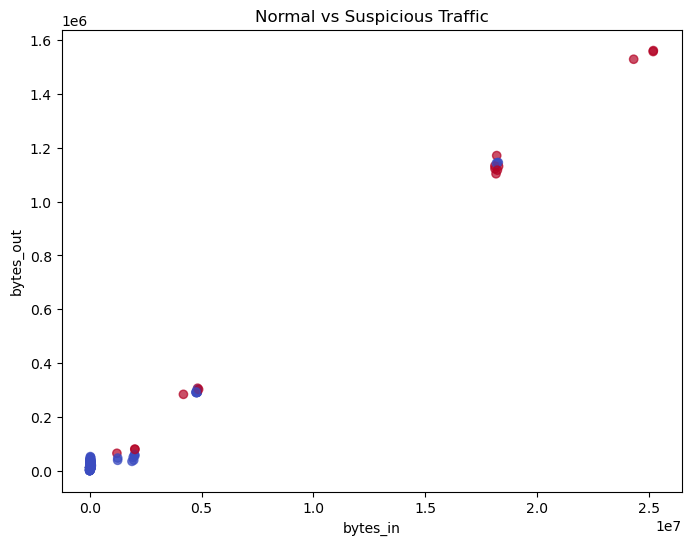

In [75]:
print(df_transformed['anomaly'].value_counts())

suspicious_df = df_transformed[df_transformed['anomaly']=='Suspicious'] 
suspicious_df.head()

import matplotlib.pyplot as plt 
plt.figure(figsize=(8,6))
plt.scatter(df_transformed['bytes_in'], df_transformed['bytes_out'], 
            c=(df_transformed['anomaly']=='Suspicious'), cmap='coolwarm', alpha=0.7)
plt.xlabel('bytes_in') 
plt.ylabel('bytes_out')
plt.title("Normal vs Suspicious Traffic")
plt.show()

✅ Final Deliverables

-Suspicious sessions saved in outputs/suspicious_results.csv
-Traffic statistics summary in outputs/traffic_stats_summary.csv
-Visualization in outputs/anomaly_scatter_plot.png